# About the notebook

The idea was to improve the recognition of the digit readout in the watermeter project <https://github.com/jomjol/AI-on-the-edge-device>

<img src="https://raw.githubusercontent.com/jomjol/AI-on-the-edge-device/master/images/powermeter.jpg" width="600">


The problem was the intermediate states between to full states of the digits. The previous model could not recognize intermediate states between two digits. It has a 11 class "NaN". A post-network algorithm handled the exceptions, but was not ideal.

So if we could identify the intermediate states, the model would also become more accurate.

## The datasets

### tenth of step of TMNIST

Because of the smaller amount of real data, the notebook uses fonts where the intermediate states were created using two consecutive numbers and their shift.

The mount of data are round about 280.000 images or 2.8000 in each class.

### tenth of step of meter digits

The real data comes from the edge AI devices of users collected with help of a small tool collects the data from the devices and helps on labeling (https://github.com/haverland/collectmeterdigits)




We need a newer tensorflow version

In [1]:
#!pip install -U tensorflow -q
import tensorflow as tf
tf.__version__

'2.6.4'

### Extract datasets and utils

TMNST dataset, meter digits dataset and util functions will be extracted to workdir.

In [2]:
import os
import  tarfile
#tmnist_dir = "tmnist"
b2n_dir = "b2n"
meterdigits_dir="meterdigits"

# untar the datasets
#os.makedirs(tmnist_dir, exist_ok=True)
#with  tarfile.open("/kaggle/input/tenth-of-step-of-tmnist/datasets.tar", 'r:*') as tar:
#    tar.extractall(tmnist_dir)
if (not os.path.exists(meterdigits_dir)):
    os.makedirs(meterdigits_dir, exist_ok=True)
    with  tarfile.open("/kaggle/input/tenthofstepofmeterdigits/datasets.tar", 'r:*') as tar:
        tar.extractall(meterdigits_dir)

if (not os.path.exists(b2n_dir)):
    os.makedirs(b2n_dir, exist_ok=True)
    with  tarfile.open("/kaggle/input/b2n-utils/b2n.tar", 'r:*') as tar:
        tar.extractall(b2n_dir)

# Loading images

Because of the mass amount of data the Tensorflow Dataset will be used. It has less memory consumption.

The tmnist dataset contains round about 280.000 images.

The meter digit dataset contains 12.000 images.

In [3]:
import numpy as np
import tensorflow as tf

batch_size = 32

#tmnist_train_ds = tf.keras.utils.image_dataset_from_directory(directory=tmnist_dir+'/tmnist', image_size=(32,20), batch_size=batch_size,
#                                            color_mode='rgb',label_mode='categorical', shuffle=True,
#                                            seed=1232, validation_split=0.2, subset="training")
#tmnist_val_ds = tf.keras.utils.image_dataset_from_directory(directory=tmnist_dir+'/tmnist', 
#                                            image_size=(32,28), batch_size=batch_size, color_mode='rgb', label_mode='categorical',
#                                            shuffle=True, seed=1232, validation_split=0.2, subset="validation")

meterdigits_train_ds = tf.keras.utils.image_dataset_from_directory(directory=meterdigits_dir +'/meterdigits', image_size=(32,20), batch_size=batch_size,
                                            color_mode='rgb',label_mode='categorical', shuffle=True,
                                            seed=1232, validation_split=0.2, subset="training")
meterdigits_test_ds = tf.keras.utils.image_dataset_from_directory(meterdigits_dir +'/meterdigits', image_size=(32,20), batch_size=batch_size, 
                                            color_mode='rgb', label_mode='categorical', shuffle=True, 
                                            seed=1232, validation_split=0.2, subset="validation")

Found 12319 files belonging to 100 classes.
Using 9856 files for training.


2022-06-18 18:37:04.178190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 18:37:04.332114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 18:37:04.333644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 18:37:04.342511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 12319 files belonging to 100 classes.
Using 2463 files for validation.


## Look on the meter digit dataset

The yellow lines are only help lines for manual labeling. 

The pictures are very different. Some are smaller, other has reflections and in all colors with different fonts.

2022-06-18 18:37:08.650850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


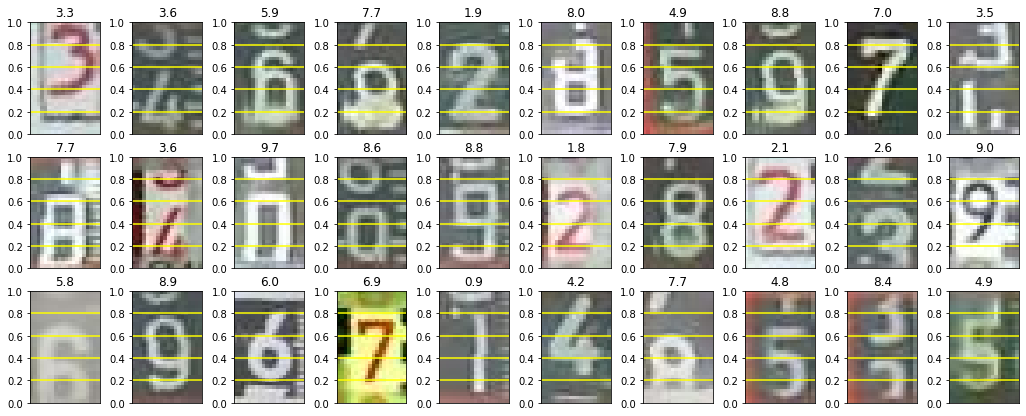

In [4]:
import matplotlib.pyplot as plt

data_iter = meterdigits_train_ds.as_numpy_iterator()

fig = plt.figure(figsize=(18, 7))
for i in range(1, 30 +1):
    img, label = data_iter.next()
    fig.add_subplot(3, 10, i)
    plt.title(np.argmax(label)/10)  # set title
    plt.imshow(img[0].astype(np.uint8), aspect='1.6', extent=[0, 1, 0, 1])
    plt.gca().get_xaxis().set_visible(False) 
    [plt.axhline(y=y,color='yellow') for y in np.arange(0.2, 0.8, 0.2)] # yellow lines           
plt.show()

### Divergence of the digit meter dataset

The tmnist dataset has for each class the same count. The digit meter dataset is collected and evenly distributed.

As we can see, the most frequent records are always near the full number.

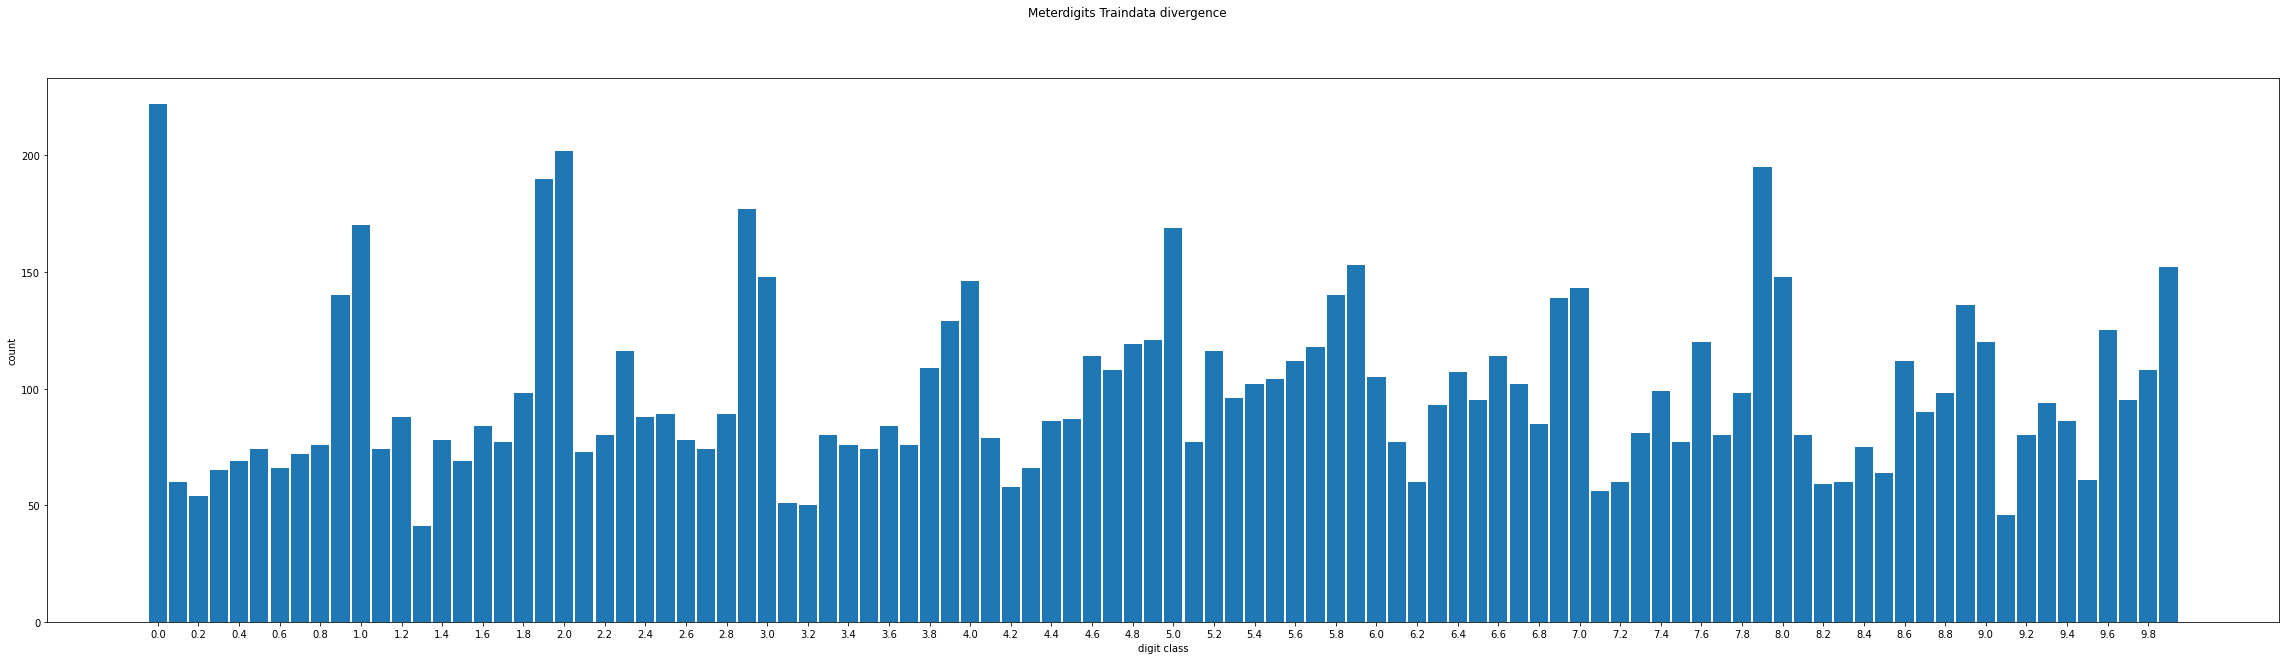

In [5]:
y = np.concatenate([y for x, y in meterdigits_train_ds], axis=0)

fig = plt.figure(figsize=(40, 10))
fig.suptitle('Meterdigits Traindata divergence')
plt.bar(np.arange (0, 10, 0.1), np.bincount(np.argmax(y, axis=1)), width=0.09, align='center')
plt.ylabel('count')
plt.xlabel('digit class')
plt.xticks(np.arange(0, 10, 0.2))
plt.show()

## The model

It is not a small model and does not fit on the edge AI device, but can be later used for knowledge distillation.

In [6]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(32,20,3), activation='relu'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation=None))


model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])


## Augmentation

Augementation for the digit can not use flipping or to much shifting (only horizontal).

But invert will be used (later for the tmnist) and contrast and brightness changes.

Only the train dataset will be augmentated. So the validation accuracy is in the first epochs higher but we want to know how the model predicts the real data.

In [7]:
import tensorflow as tf 
import tensorflow.keras.layers as layers
import random

def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x
    
layer_augs = tf.keras.Sequential([
  layers.RandomContrast(0.2),
  layers.RandomTranslation(height_factor=.0, width_factor=.2),
  #layers.RandomBrightness(factor=0.2),
  layers.RandomRotation(factor=0.01)
])

aug_meterdigits_train_ds = meterdigits_train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)).cache(
    ).map(   lambda image, label: (random_invert_img(image), label)
    ).map(   lambda image, label: (layer_augs(image, training=True), label)
    )


A short look at the augmentated data to see if the values of rotation, shifting and so on not to much.

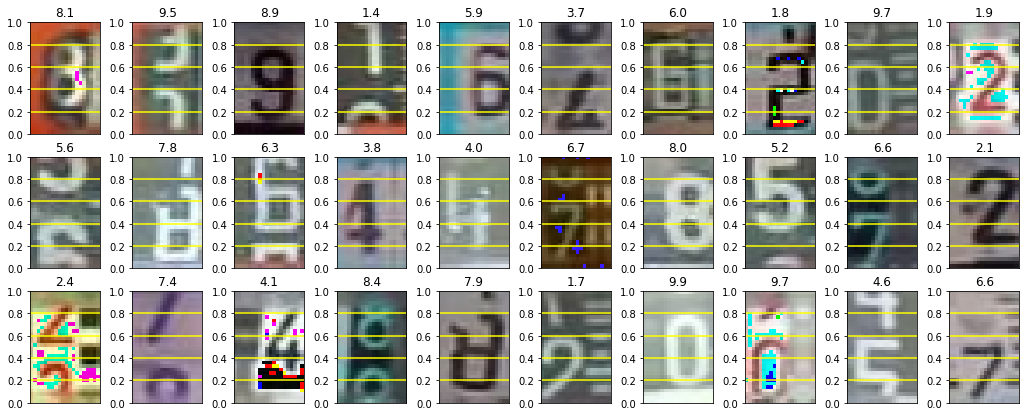

In [8]:
import matplotlib.pyplot as plt

data_iter = aug_meterdigits_train_ds.as_numpy_iterator()

fig = plt.figure(figsize=(18, 7))
for i in range(1, 30 +1):
    img, label = data_iter.next()
    fig.add_subplot(3, 10, i)
    plt.title(np.argmax(label[0])/10)  # set title
    plt.imshow(img[0].astype(np.uint8), aspect='1.6', extent=[0, 1, 0, 1])
    plt.gca().get_xaxis().set_visible(False) 
    [plt.axhline(y=y,color='yellow') for y in np.arange(0.2, 0.8, 0.2)] # yellow lines           
plt.show()

#### 

### The Training



Epoch 1/30


2022-06-18 18:37:20.150354: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


308/308 - 13s - loss: 4.6666 - accuracy: 0.0147 - val_loss: 4.5772 - val_accuracy: 0.0260
Epoch 2/30
308/308 - 4s - loss: 3.9285 - accuracy: 0.0948 - val_loss: 2.5396 - val_accuracy: 0.2692
Epoch 3/30
308/308 - 4s - loss: 2.1160 - accuracy: 0.3762 - val_loss: 1.1663 - val_accuracy: 0.5778
Epoch 4/30
308/308 - 4s - loss: 1.3574 - accuracy: 0.5480 - val_loss: 0.8419 - val_accuracy: 0.6841
Epoch 5/30
308/308 - 4s - loss: 1.0682 - accuracy: 0.6381 - val_loss: 0.6560 - val_accuracy: 0.7450
Epoch 6/30
308/308 - 4s - loss: 0.9143 - accuracy: 0.6786 - val_loss: 0.6602 - val_accuracy: 0.7564
Epoch 7/30
308/308 - 4s - loss: 0.8234 - accuracy: 0.7058 - val_loss: 0.6143 - val_accuracy: 0.7694
Epoch 8/30
308/308 - 4s - loss: 0.7369 - accuracy: 0.7375 - val_loss: 0.5515 - val_accuracy: 0.7917
Epoch 9/30
308/308 - 4s - loss: 0.7066 - accuracy: 0.7500 - val_loss: 0.5609 - val_accuracy: 0.7946
Epoch 10/30
308/308 - 4s - loss: 0.6521 - accuracy: 0.7644 - val_loss: 0.5910 - val_accuracy: 0.7755
Epoch 11/

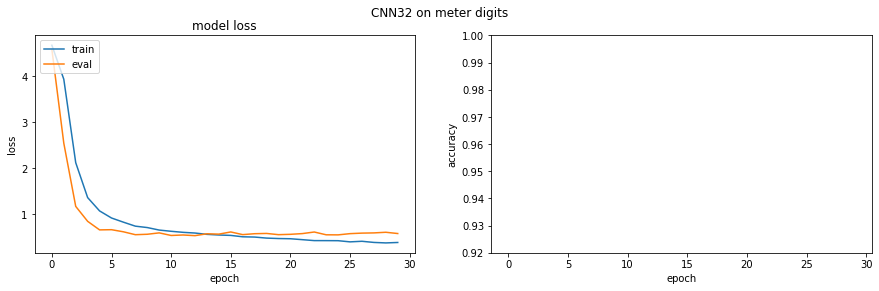

In [9]:
from b2n.plotfunctions import plot_acc_loss
history = model.fit(meterdigits_train_ds, 
                validation_data=meterdigits_test_ds, 
                batch_size=32, 
                epochs = 30,
                verbose=2)

plot_acc_loss(history, 'CNN32 on meter digits')

### Validate on all digit meter

Here we want to know wich images are not correctly predicted and why. It can in case of false predicted or other cases.

We see 99% of false predicted have a deviation <0.14. And many of them are false predicted.


Ziffer data count:  12319
Tested images: 12319. 1199 false predicted. Accuracy is: 0.9026706713207241


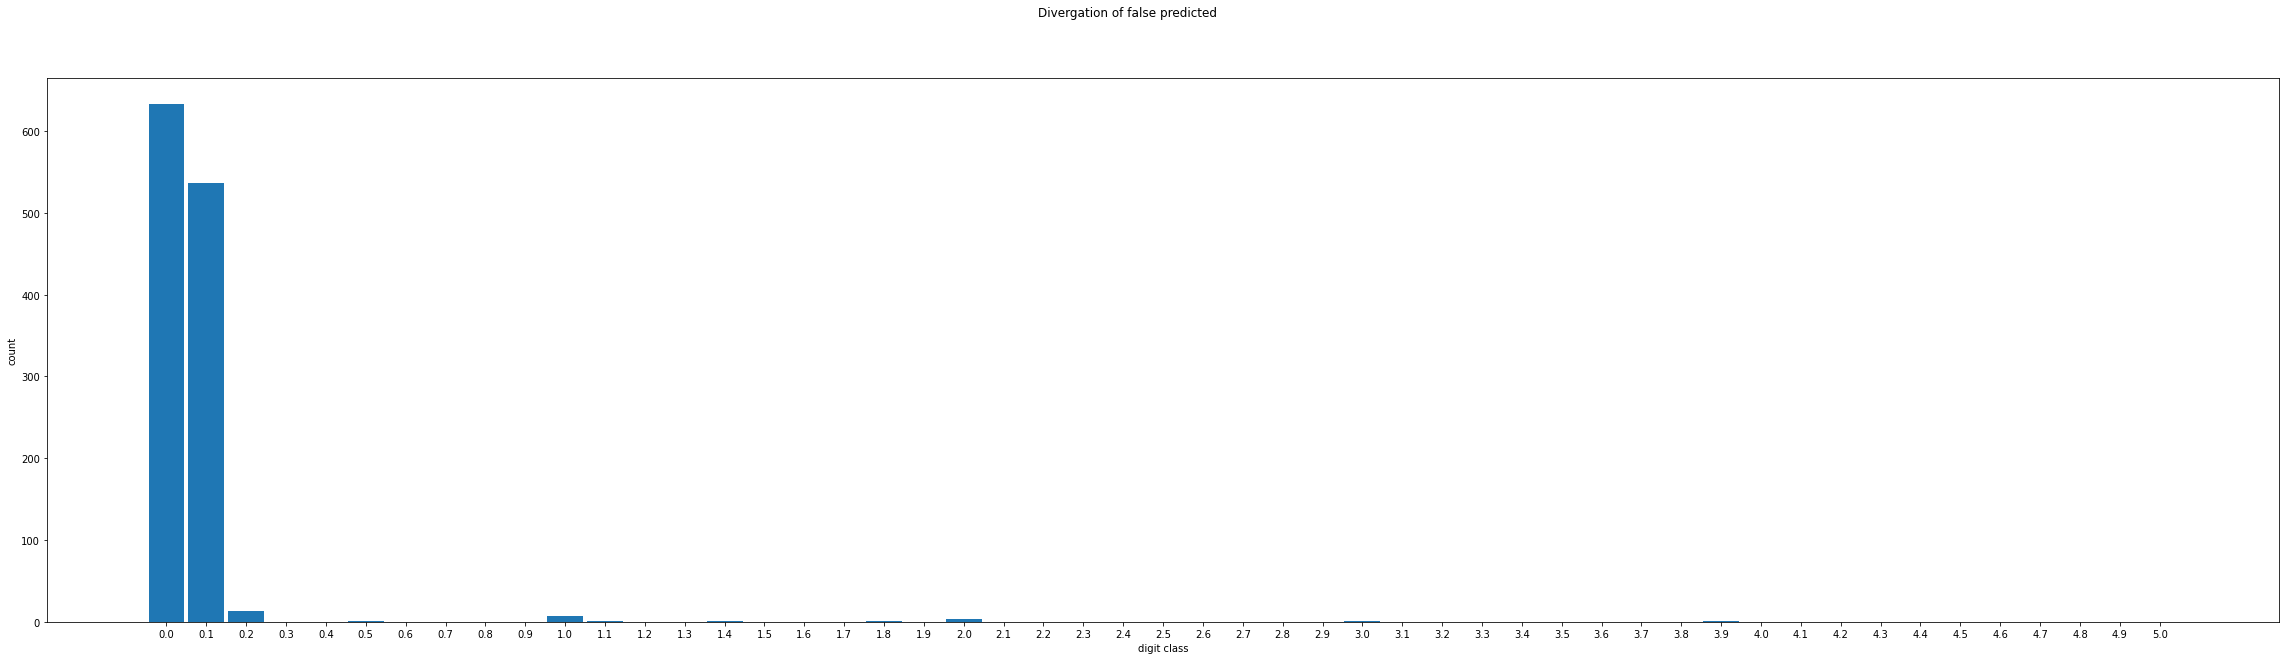

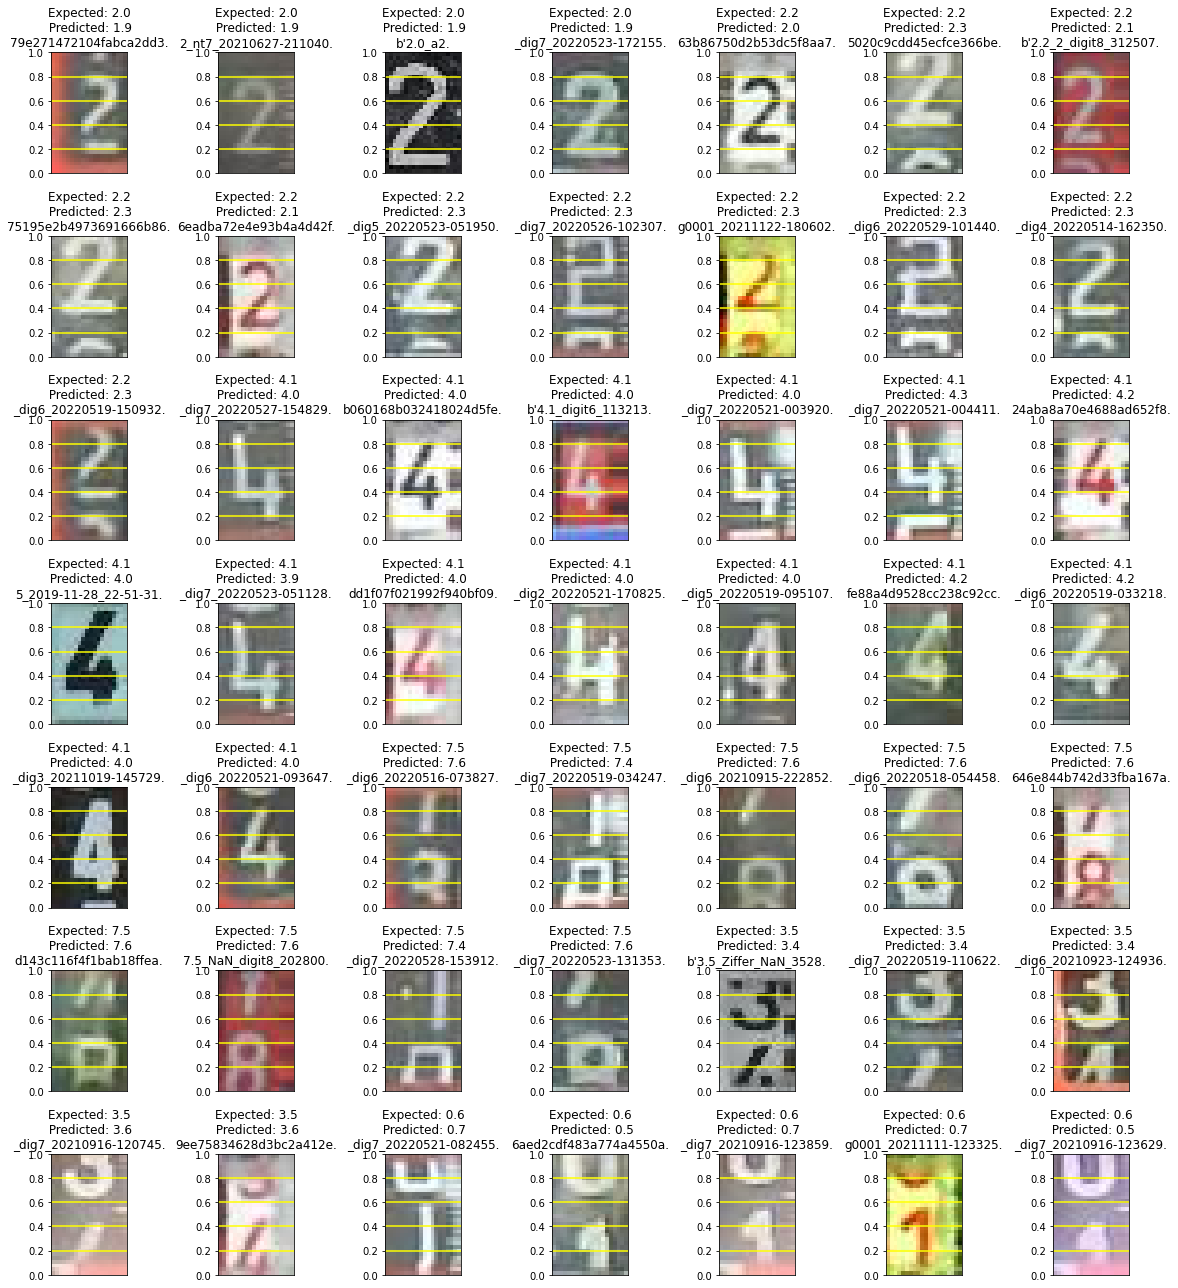

In [10]:
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import predict_meter_digits

# read the meter digits dataset
xz_data, yz_data, fz_data = ziffer_data(meterdigits_dir)
    
predict_meter_digits(model, xz_data, yz_data, fz_data,  max_delta = 0.02)


Ziffer data count:  12319
Tested images: 12319. 31 false predicted. Accuracy is: 0.9974835619774333


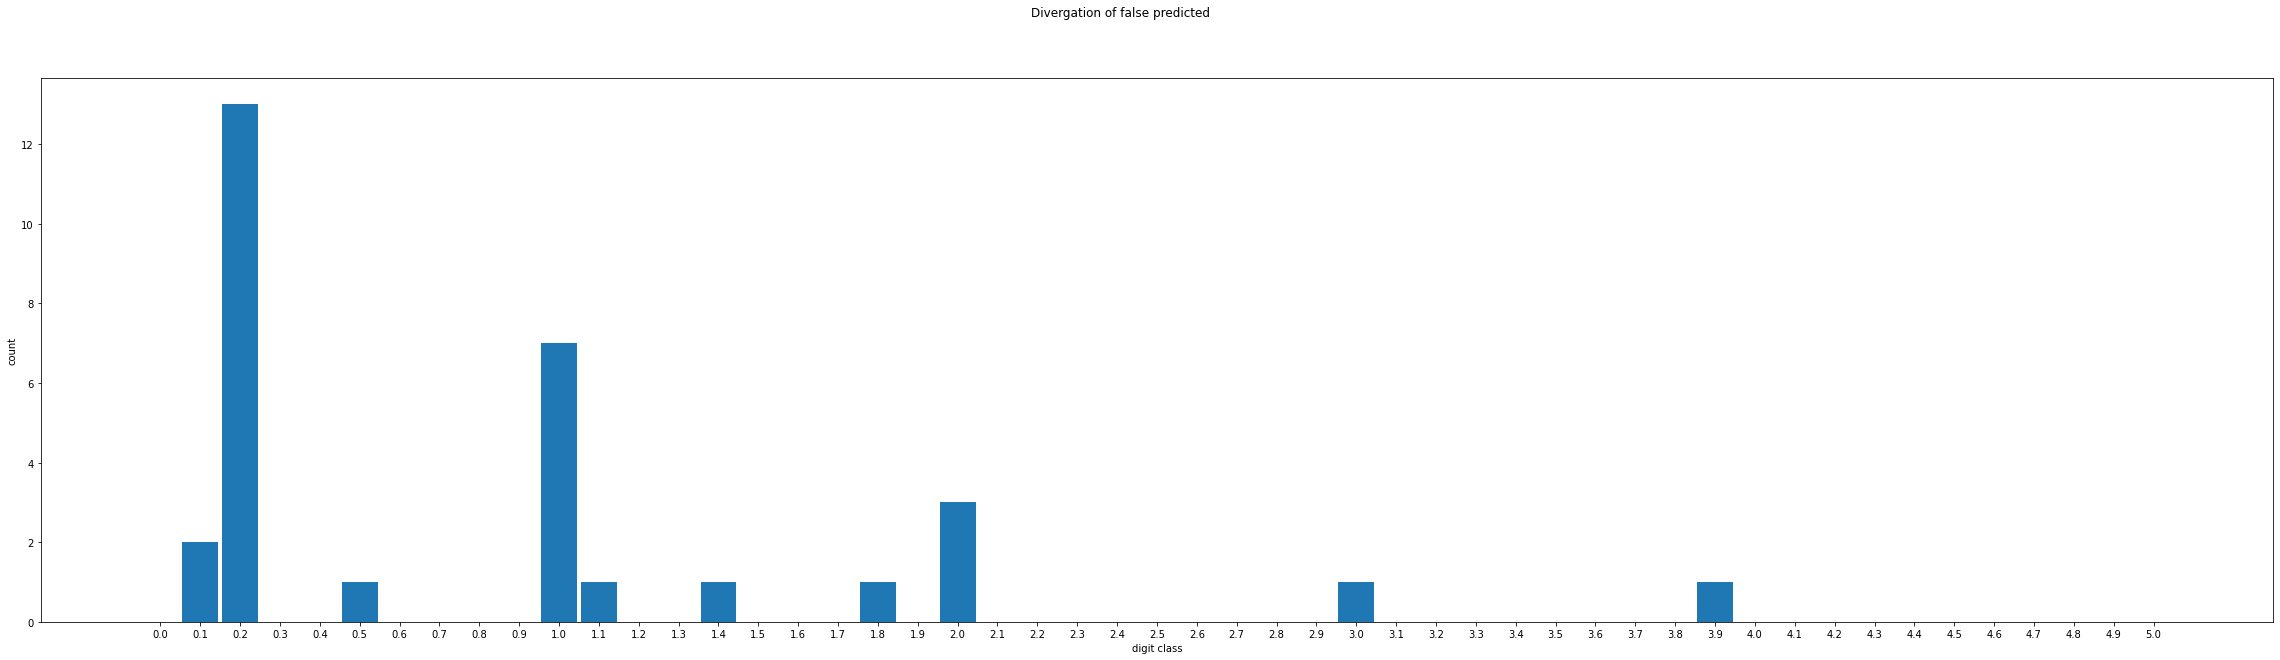

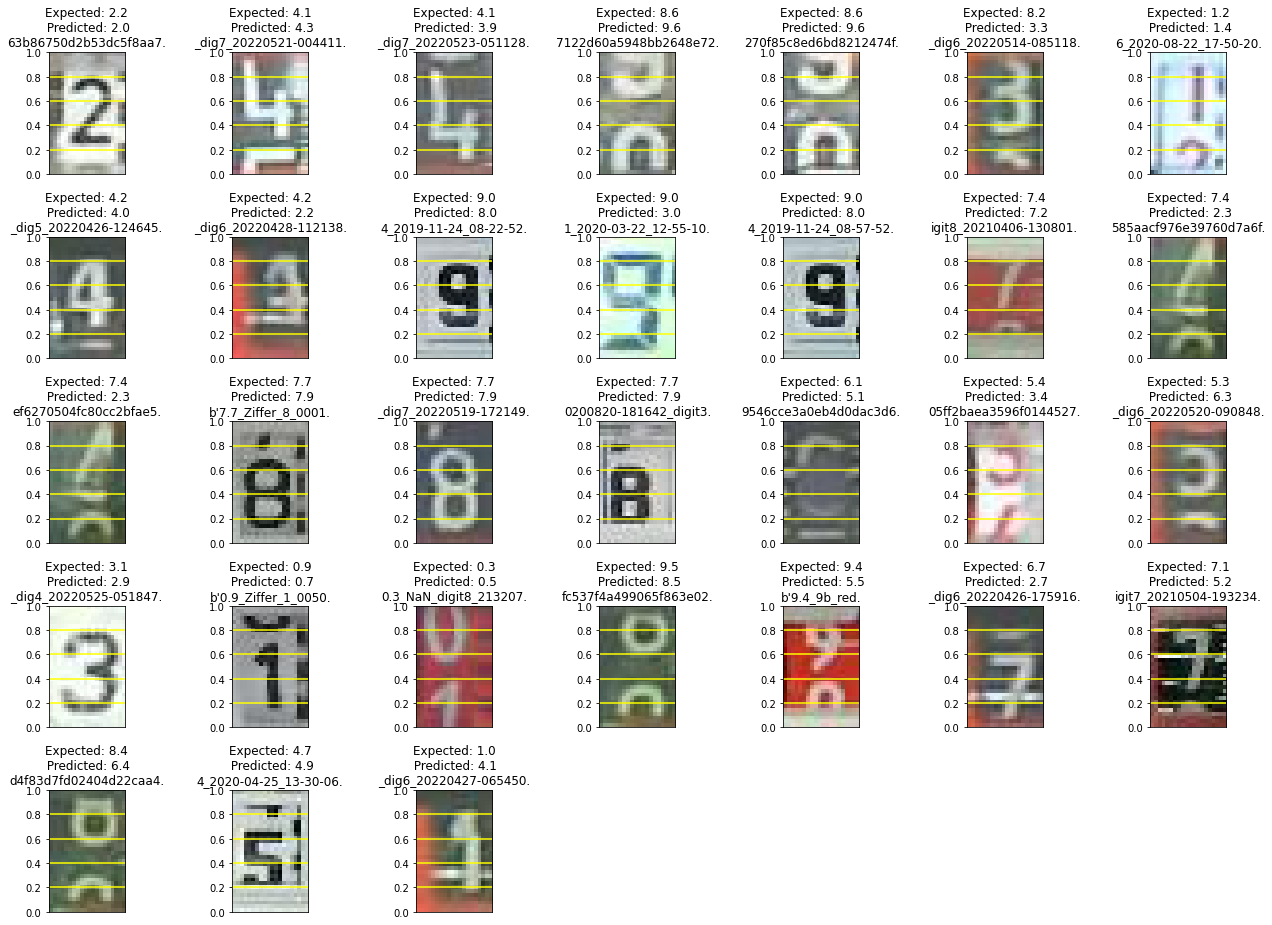

In [11]:
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import predict_meter_digits

# read the meter digits dataset
xz_data, yz_data, fz_data = ziffer_data(meterdigits_dir)
    
predict_meter_digits(model, xz_data, yz_data, fz_data,  max_delta = 0.14)